In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
""" 결정트리 예시 """

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[ : , 2 : ]
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",
    feature_names=iris.feature_names[2: ],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

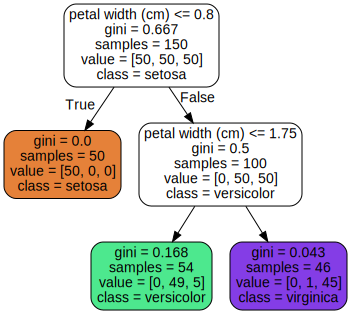

In [4]:
import graphviz
with open("iris_tree.dot") as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='iris_tree', directory='.', cleanup=True)
dot

결정 트리의 장점 중 하나는 데이터 전처리가 거의 필요 없다는 점 <br>
\>>> 스케일링 등이 필요 없음 <br>

그래프 해석
- sample: class로 분류된 샘플 수
- value: 훈련 샘플의 원래 레이블 별로 class로 분류된 수<br>
versicolor의 경우 정답이 versicolor인 샘플 49개, 정답이 virginica인 샘플 5개가 versicolor로 분류됐다
- genie: 불순도

지니 불순도?
- 각 노드의 순도를 나타내는 척도. 즉 결과가 얼마나 깔끔한지 나타내는 척도
- 값은 0~0.5 사이
- 구하는 방법은 다음과 같다
> $G_i=1-\sum_{k=1}^n {p_{i, k}}^2$ ($p_{i, k}$: i 번째 노드에 있는 훈련 샘플 중 클래스 k에 속한 샘플 비율)
- 위 정의대로라면, 클래스 k에 속한 샘플이 아주 많아도, 아주 적어도 순도는 높게 나온다

사이킷런은 이진 트리만 생성 가능하다 (CART 알고리즘)<br>
\>>> 질문의 답으로 YES or NO만 가능 <br>

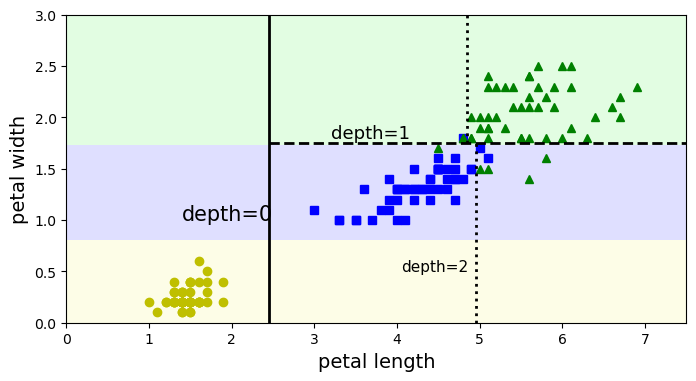

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("petal length", fontsize=14)
        plt.ylabel("petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "depth=0", fontsize=15)
plt.text(3.2, 1.80, "depth=1", fontsize=13)
plt.text(4.05, 0.5, "depth=2", fontsize=11)

plt.show()

#### 화이트박스 모델? 블랙박스 모델? <br>
<br>
화이트박스 모델: 결과 확인 O, 결정 방식 확인 O. 대표 사례: 결정 트리 <br>
블랙박스 모델: 결과 확인 O, 결정 방식 확인 X. 대표 사례: 신경망, 랜덤 포레스트

# 클래스 확률 추정

어떤 샘플이 특정 클래스에 속할 것이라고 예측하는 것이 아닌, ~% 확률로 특정 클래스일 것을 추정하는 것 <br>
ex. 길이가 ~이고 너비가 ~인 표본은 90% 확률로 Versicolor<br>
<br>
결정 트리는 클래스 레이블이 아닌, 확률도 알아낼 수 있다 >>> predict_proba 제공

In [8]:
""" 해석: 클래스 1에 속할 확률 ~91% """
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [9]:
""" 해석: 클래스 1로 분류 """

tree_clf.predict([[5, 1.5]])

array([1])

# CART(Classification and Regression Tree)

과정  
1. 훈련 세트를 가장 순수한 서브셋으로 나눌 수 있는 특성 $k$의 임계값 $t_k$ >>> $\left (k, t_k \right )$ 쌍을 찾아낸다<br>
즉 $t_k$로 나눴을 때 가장 불순도가 낮은 특성 $k$를 찾아낸다
2. 훈련 세트를 하나의 특성 $k$의 임계값 $t_k$를 사용해 두 개의 서브셋으로 나눈다
3. 중지 조건에 도달하거나 (최대 리프 노드, 최대 높이 등...) 더 깔끔하게 나누지 못할 때까지 2를 반복한다

여기서 $\left (k, t_k \right )$는 다음 비용함수를 최소하하는 값으로 한다  
> $ J(k, t_k)={ m_{left} \over m}G_{left} + {m_{right} \over m}G_{right}$

이때
- $G_{left}, G_{right}$ : 왼쪽/오른쪽 서브셋의 불순도
- $m_{left}, m_{right}$ : 왼쪽/오른쪽 서브셋의 샘플 수

주의사항  
- 이렇게 만든 트리는 **최적이 아니라 봐줄 만한 결과이다**<br>
왜냐하면 CART는 greedy한 알고리즘이라 그 다음 분할까지 불순도가 가장 낮게 할지는 고려하지 않기 때문이다 
- 만약 진짜 최적의 트리를 찾아내려면 $\mathbf {\mathit O} (\exp(m)) $만큼의 시간이 필요하다<br>
진짜 최적의 트리를 찾아내는 문제는 NP 완전 문제이다<br>

NP 완전?

    - P 문제: 다항 시간 안에 풀 수 있는 문제
    - NP 문제: 다항 시간 안에 답을 검증할 수 있는 문제 (검산만 다항 시간 안에 가능하다는 말?)
    - NP 난해: 모든 NP 문제를 다항 시간 안에 축소시킬 수 있는 문제
    - NP 완전: NP + NP 난해인 문제

# 계산 복잡도

새로운 샘플을 분류할 때: $\mathbf {\mathit O} (\log_{2}(m)) $  
훈련에 걸리는 시간: $\mathbf {\mathit O} (n \times m \log (m)) $  
  
- n: 특성 수
- m: 샘플 수  
  
$n \times m \log (m)$?  
- 특성 별로 정렬을 수행해야 하기 때문 (이때 퀵 정렬 사용)
- 훈련 세트가 커진다면 정렬로 인해 (==$m\log m$ 때문에) 느려진다 

# 엔트로피

사용방법:  criterion="entropy"로 설정 (기본 "gini")  
각 장점  
- 지니: 빠른 계산 속도 (로그 계산을 안하기 때문)
- 엔트로피: 지니 불순도를 쓸 때보다 비교적 균형 잡힌 트리를 형성한다  

엔트로피 계산은 다음과 같이 한다
> $ H_i = -\sum_{k=1}^n \left( p_{i, k}\log_{2} \left( p_{i, k} \right) \right)$  
(이 때 클래스에 샘플이 하나라도 있다면 $p_{i, k} \ne 0$)  

어떤 세트에 있는 샘플들이 모두 같은 클래스라면 $H_i = 0$, 반반에 가까울수록 $H_i \simeq 1$

# 규제 매개변수

#### 용어 정리

- 비파라미터 모델
    - 훈련 전 파라미터 수가 결정되지 않는 모델.
    - ~ 결정 트리
- 파라미터 모델
    - 파라미터 수가 미리 정해진 모델. 
    - ~ 선형 모델

파라미터 모델의 경우 비파라미터 모델보다 자유도가 제한되어 비교적 과대적합 가능성은 줄지만 과소적합될 위험은 커질 수 있다

sklearn의 결정 트리에서 사용할 수 있는 규제
- max_depth: 트리의 최대 깊이
- min_samples_split: 분할되기 위한 최소 샘플 수
- min_samples_leaf: 리프 노드가 가지고 있어야 할 최소 샘플 수
- min_weight_fraction_leaf: ~min_samples_leaf, 대신 비율
- max_leaf_noeds: 리프 노드의 최대 수
- max_features: 각 노드에서 분할에 사용할 특성의 최대 수
- min_impurity_decrease: 분할로 얻어질 최소한의 불순도 감소량 >>> 분할 후 불순도가 ~ 보다 높아야 함
- min_impurity_split: 분할 대상이 되기 위한 최소한의 불순도 >>> ~ 보다 높아야 분할

### 가지치기

리프 바로 위의 불필요한 노드를 없애는 방식으로 트리를 깔끔하게 만드는 방법<br>
방법
1. 사전 가지치기
    - 만들기 전 미리 모양을 제한하는 방법
    - 위에 있는 하이퍼파라미터들을 이용한다. (ex. max_depth=5, max_leaf_nodess=10 ...)

2. 사후 가지치기
    - 일단 규제를 가하지 않고 만든 뒤, 그 후에 제거하는 방법
    - 뭘 없앨지는 통계적 검정을 통해 판단한다<br>
    (ex. $\chi^2$ 검정을 통해 산출한 p값이 기준을 넘어서면 '해당 기준은 순도를 높이는 것과 관련이 있다'는 가설에 따라 나눠서 순도를 높인 것이 우연히 생성된 결과로 보고 제거.)
    - 단, 사이킷런에선 불가능 (사전 가지치기만 지원)

# 트리를 이용한 회귀

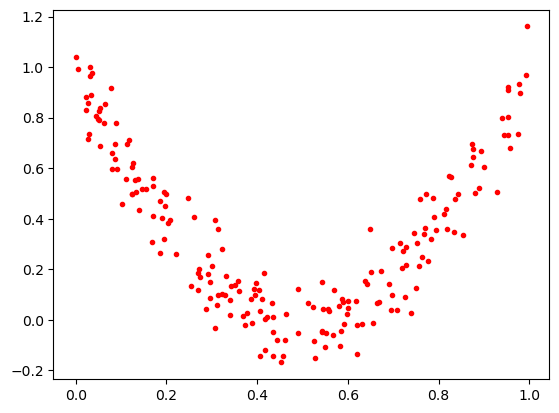

In [10]:
X = np.random.rand(200, 1)
y = 4*(X-0.5)**2
y = y + np.random.randn(200, 1) / 10

plt.plot(X, y, "r.")

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

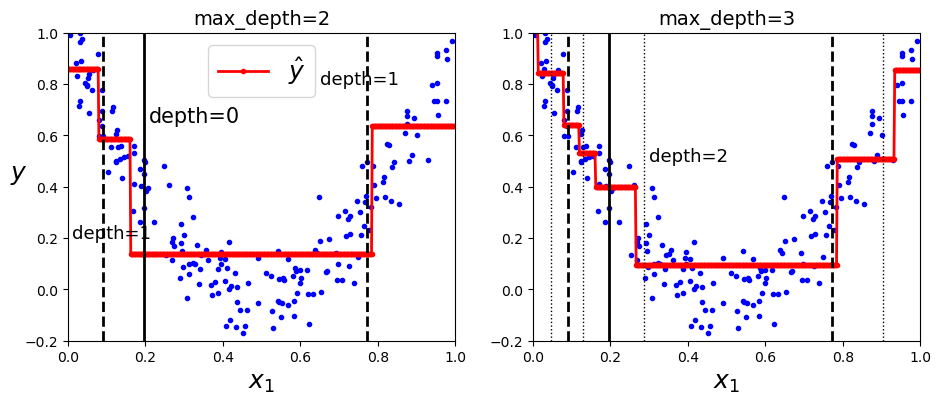

In [12]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "depth=0", fontsize=15)
plt.text(0.01, 0.2, "depth=1", fontsize=13)
plt.text(0.65, 0.8, "depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

In [13]:
export_graphviz(
    tree_reg1,
    out_file="tree_reg1.dot",
    rounded=True,
    filled=True
)

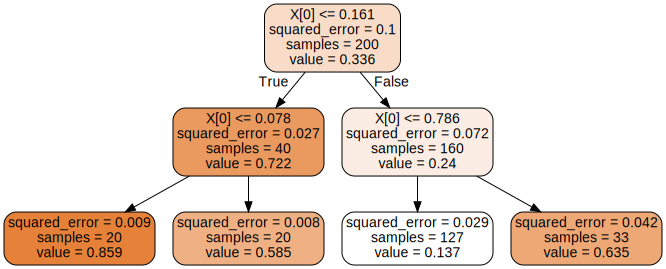

In [14]:
with open("tree_reg1.dot") as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='tree_reg1', directory='.', cleanup=True)
dot

In [15]:
export_graphviz(
    tree_reg2,
    out_file="tree_reg2.dot",
    rounded=True,
    filled=True
)

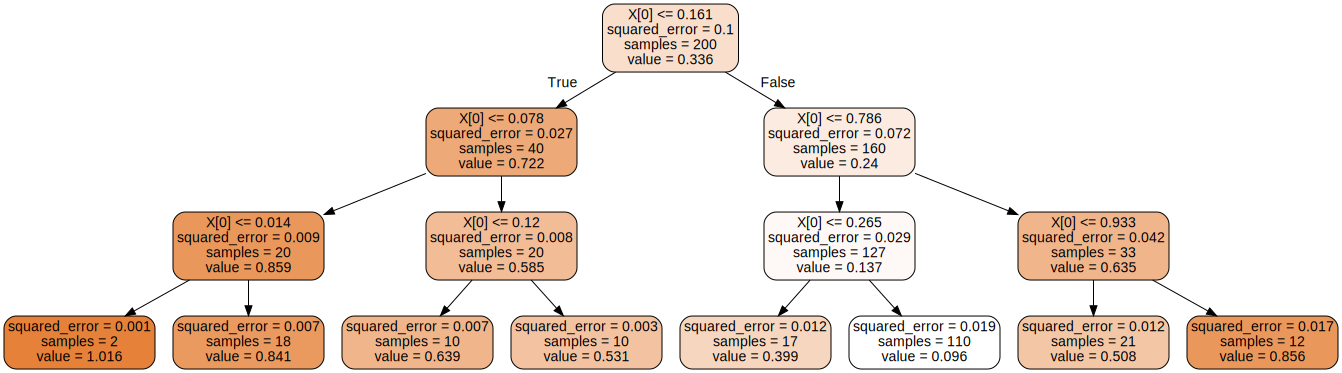

In [16]:
with open("tree_reg2.dot") as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='tree_reg2', directory='.', cleanup=True)
dot

트리를 회귀 작업에 이용할 경우 CART 알고리즘의 비용함수로 불순도 대신 MSE를 사용한다<br>
식은 다음과 같다 >>> 불순도 대신 MSE가 들어간 모습
> $J(k, t_k)= { m_{left} \over m }\mbox{MSE}_{left} + { m_{right} \over m } \mbox{MSE}_{right} $  

이 때
- 각 노드의 MSE: $\mbox{MSE}_{node} = \sum_{ i \in \mbox{node} } \left ( \hat{y}_{node} - y^{(i)} \right )^2$
- 노드의 예측값 $\hat{y}_{\mbox{node}} = { 1\over m_{node}} \sum_{i \in \mbox{node}} \hat{y}^{(i)}$

??? 노드의 예측값?
- 노드 별 범위에 들어온 샘플에 대한 회귀 결정 트리의 예측 값
- 위의 max_depth=3인 모델을 예를 들면 X>0.933인 샘플은 예측 결과로 0.856, X<=0.12인 샘플은 예측 결과로 0.639를 내놓는다
- 회귀선은 각져있는 모습이어서 좀 더 정확하게 예측하려면 트리를 더 복잡하게 만들어야 한다

# 트리의 단점

1. 훈련 세트의 회전에 민감하다
    - 계단 모양의 경계를 만드는 것이 원인
    - p.237의 그림을 예로 들면 회전했을 때 그냥 사선으로 쭉 나눌 수 있는 것을 계단 모양으로 각지게 만들었다
    - 회전으로 인한 일반화 오류 증가를 막기 위한 방법 중 하나는 좀 더 나은 방향으로 돌리는 것 >>> PCA 등 활용
2. 훈련 데이터의 작은 변화에도 민감해서 같은 데이터에서도 다른 모델이 나올 수 있다.
    - 특히 sklearn의 트리 모델은 무작위성으로 인해 완전 똑같은 데이터로도 다른 결과가 나올 수 있다
        - max_features를 지정하면 전체 특성 중 일부를 무작위로 골라 사용하고, 지정하지 않으면 전체 특성을 사용한다
    - 무작위성을 완화하려면
        - random_state를 지정하거나
        - 아예 필요한 특성만 뽑아내 훈련시키거나
        
극복 방법: 아예 트리 여러 개를 만들어 예측을 평균한다 >>> 랜덤 포레스트